In [124]:
import requests
import inspect
import pytz
import pandas as pd
import numpy as np

from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import (YEARLY, DateFormatter,rrulewrapper, RRuleLocator, drange)
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from time import ctime   # ctime converts epoch time (ex:1661522400) to string form (Thu Aug 25 16:00:00 2022)
from time import gmtime   # Convert a time expressed in seconds since the epoch to a struct_time in UTC in which the dst flag is always zero.
from time import localtime # Like gmtime() but converts to local time.

from datetime import datetime, timedelta
today = datetime.now()
import datetime as dt

import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 20




### 2 fichiers créés par node-red et mis à jour toutes les heures avec openweather node dans onglet Temp/Hum

#### json_file ="C:/Users/jean/OneDrive/Bureau/5days.txt"

#### json_file ="Y:/Documents/5days.txt"

#### le fichier contient une liste de 40 lignes :
- une ligne = 3 heures, 
- 8 lignes par jour 
- sur 5 jours


In [125]:
try:
    json_file = "Y:/Documents/5days.txt"  # pc cuisine
    current = pd.read_json(json_file)
except:
    json_file = "Z:/Documents/5days.txt"  # pc chambre
    current = pd.read_json(json_file)

In [126]:
#current['dates'] = [datetime.fromtimestamp(current.dt[k], pytz.timezone('Europe/Paris')) for k in range(40)]
current['dates'] = [datetime.fromtimestamp(current.dt[k]) for k in range(40)]
current['h_date'] = [datetime.fromtimestamp(current.dt[k]).strftime('%d/%m/%Y %H:%M:%S') for k in range(40)]
current['h_time'] = [datetime.fromtimestamp(current.dt[k]).strftime('%H') for k in range(40)]
current.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp        40 non-null     float64       
 1   feels_like  40 non-null     float64       
 2   temp_min    40 non-null     float64       
 3   temp_max    40 non-null     float64       
 4   pressure    40 non-null     int64         
 5   sea_level   40 non-null     int64         
 6   grnd_level  40 non-null     int64         
 7   humidity    40 non-null     int64         
 8   temp_kf     40 non-null     float64       
 9   dt          40 non-null     int64         
 10  dates       40 non-null     datetime64[ns]
 11  h_date      40 non-null     object        
 12  h_time      40 non-null     object        
dtypes: datetime64[ns](1), float64(5), int64(5), object(2)
memory usage: 4.2+ KB


In [127]:
debut = current.head(1).h_date[0]
fin = current.tail(1).h_date[39]
debut, fin

('03/12/2024 13:00:00', '08/12/2024 10:00:00')

<Axes: >

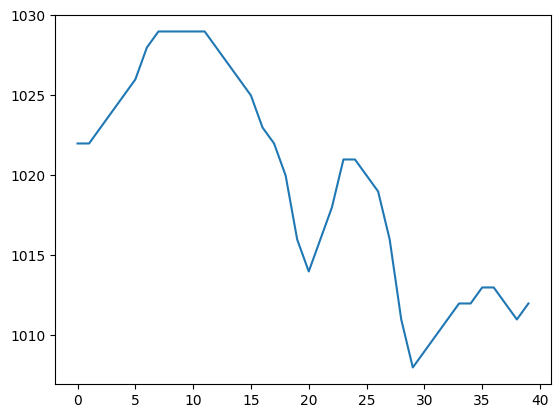

In [128]:
current.pressure.plot()


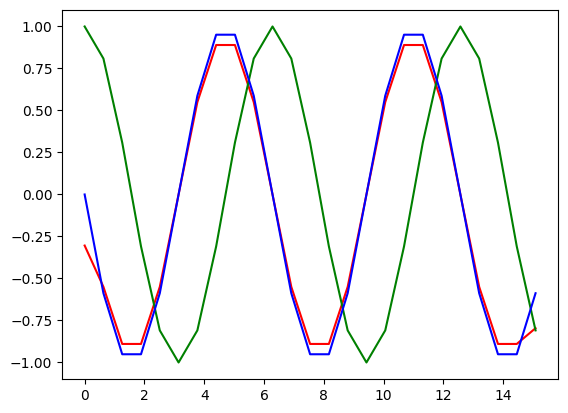

In [129]:
pi = np.pi
x = np.arange(0,5*pi,0.2*pi)
y = np.cos(x) 
# derivative dy/dx = -sin(x)
der = np.gradient(y,x)
plt.plot(x, der, 'r', x, y, 'g', x, -np.sin(x),'b')
plt.show()

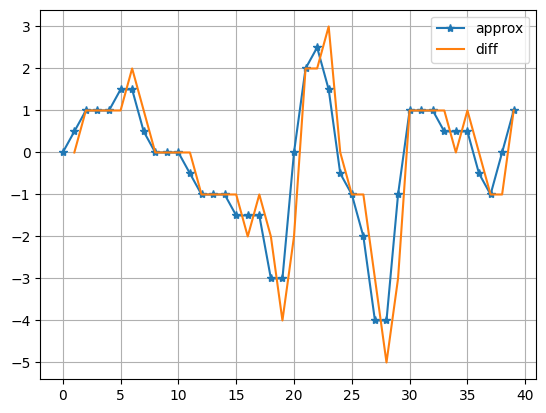

In [130]:
# derivative of pressure
dy = current.pressure#.diff()
#dy.plot()
# we sample a sin(x) function
dx = current.index.step
x = np.arange(0,40)
#current.pressure.diff().plot(label='diff')
# we calculate the derivative, with np.gradient
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
#plt.plot()
dy.diff().plot(x=x,label='diff')
plt.legend()
plt.grid()


<Axes: >

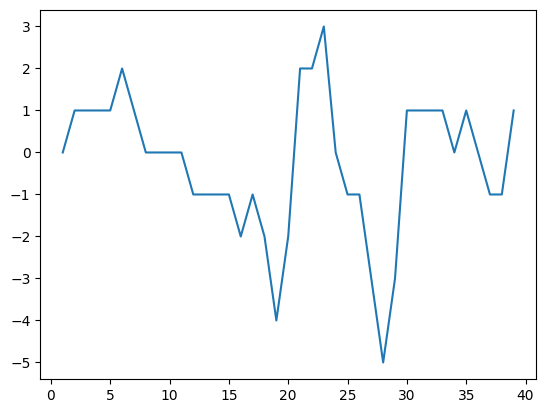

In [131]:
dy.diff().plot()

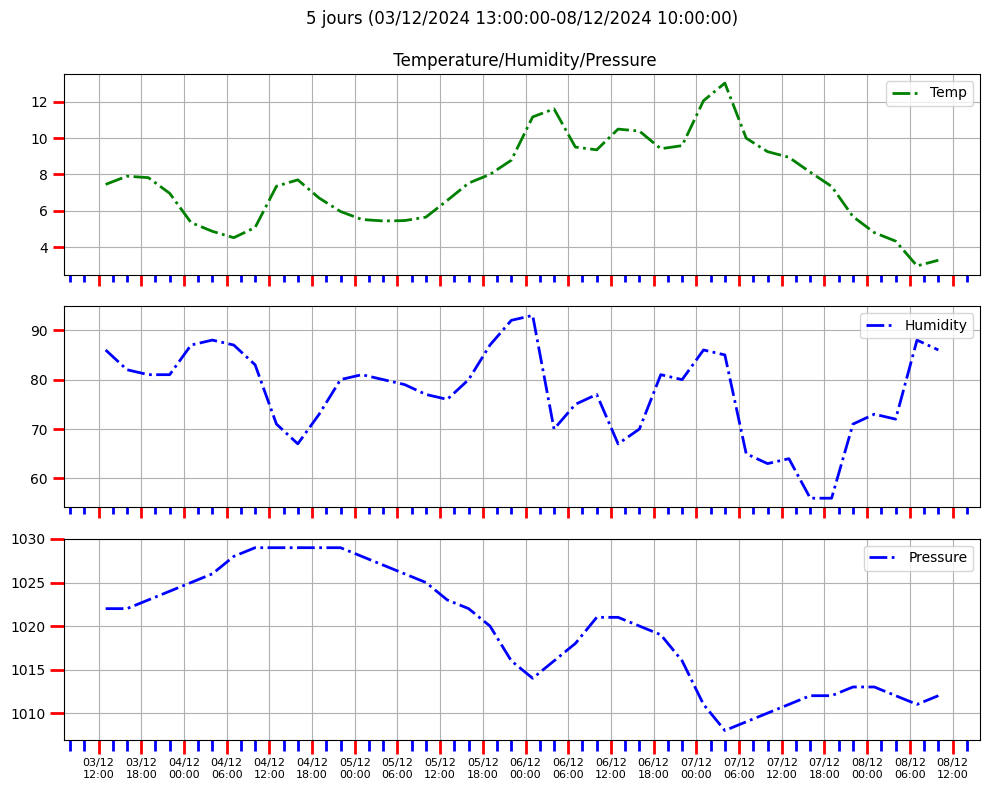

In [132]:
#fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig, (ax1,ax2,ax3) = plt.subplots(3, sharex=True)
# the size of A4 paper
fig.set_size_inches(10, 8)

ax1.tick_params('x', labelsize=8)
ax2.tick_params('x', labelsize=8)
ax3.tick_params('x', labelsize=8)

# format affichage dates sur axe des x
formatter = DateFormatter('%d/%m\n%H:%M')
#ax1.xaxis.set_major_formatter(formatter)
#ax2.xaxis.set_major_formatter(formatter)
ax3.xaxis.set_major_formatter(formatter)

# nombre de ticks sur axe des x
major_ticks = 1/4                    # toutes les 6 heures pour 1/4, 12h pour 1/2
minor_ticks = major_ticks/3          # facteur div = 4  -> minor ticks toutes les 3 heures

# temperature
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  # ???? pas d'affichage des minor ticks ???
# format des ticks
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=8, color='r')
ax1.tick_params(which='minor', length=5, color='b')
#plot
ax1.plot(current.dates,current.temp,'g-.',label='Temp',linewidth=2)
#plt.plot(current.dates,current.temp_max,'r-.',label='Max',linewidth=2)
#plt.plot(current.dates,current.temp_min,'b-.',label='Min',linewidth=2)

# humidity
ax2.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax2.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax2.tick_params(which='both', width=2)
ax2.tick_params(which='major', length=8, color='r')
ax2.tick_params(which='minor', length=5, color='b')
ax2.plot(current.dates,current.humidity,'b-.',label='Humidity',linewidth=2)

# pression
ax3.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax3.xaxis.set_minor_locator(MultipleLocator(minor_ticks))  
# format des ticks
ax3.tick_params(which='both', width=2)
ax3.tick_params(which='major', length=10, color='r')
ax3.tick_params(which='minor', length=8, color='b')
ax3.plot(current.dates,current.pressure,'b-.',label='Pressure',linewidth=2)

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
ax3.grid()
ax3.legend()

ax1.set_title(f'5 jours ({debut}-{fin})\n\n Temperature/Humidity/Pressure')
#ax2.set_title(f'Humidity')
fig.tight_layout()


# tendances

## temp * pression / humidity
- plus de pression, moins d'humidité = meilleure tendance

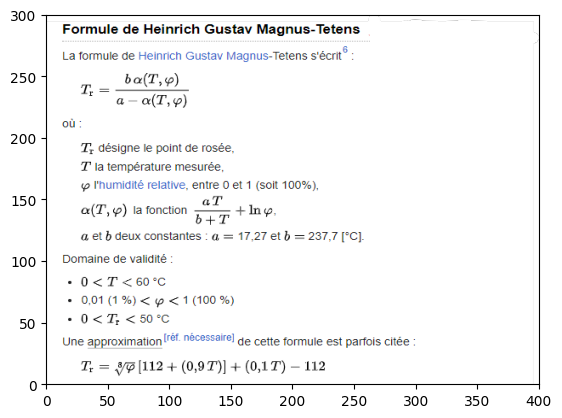

In [133]:
img = plt.imread(r"C:\Users\jean\Pictures\Screenshots\Screenshot 2024-06-04 095520.png")    # don't work with svg files
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 400, 0, 300])

Le point de rosée est une donnée thermodynamique caractérisant l'humidité dans un gaz. 
Le point de rosée de l'air est la température à laquelle la pression partielle de vapeur 
d'eau est égale à sa pression de vapeur saturante. Il s'agit donc de la température à 
laquelle il faut refroidir un volume d'air, à pression et humidité absolue constantes, 
pour qu'il devienne saturé donc il y a condensation.

La dépression du point de rosée est la différence entre la température et le point de rosée : (T-Tr)
 à un niveau de pression donnée de l'atmosphère terrestre

 https://fr.wikipedia.org/wiki/Point_de_ros%C3%A9e


La dépression du point de rosée est la différence entre la température et le point de rosée (T-Tr) à un niveau de pression donnée de l'atmosphère terrestre7. Plus cette valeur est petite, plus l’humidité relative à cette altitude est grande et plus la présence de nuages est probable. Ainsi, une dépression de plus de 5 °C est en général associée avec l'absence de couche nuageuse et une valeur près de 0 °C est synonyme d'une couverture complète. La variation dans la troposphère de la dépression du point de rosée, analysée sur un diagramme thermodynamique comme un téphigramme, permet de connaître la hauteur, l'épaisseur et l'étendue des couches nuageuses sur une région.

Text(0.5, 1.0, 'Point de rosée')

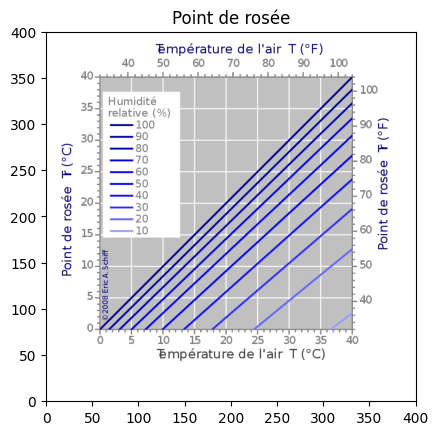

In [134]:
img = plt.imread(r"C:\Users\jean\Pictures\1024px-Dewpoint-RH-fr.svg.png")    # don't work with svg files
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 400, 0, 400])
plt.title('Point de rosée')

# si on a hum=80% à la temp=10°C, point de rosée = 7°C, depression = 10-7 = 3 < 5 (nuages)
# si on a hum=70% à la temp=10°C, point de rosée = 5°C, depression = 10-5 = 5 (clair)

In [135]:
import numpy as np
a, b = 17.27, 237.7

def alpha(T,phi):
    '''
    0 < T < 60
    0.01 < phi < 1
    '''
    return a*T/(b+T) + np.log(phi)

def dewpoint(T, phi): # phi : humidité relative
    f = alpha(T,phi)
    Tr = b*f/(a-f)
    return (T,Tr,T-Tr) #round(Tr,2), round(T-Tr,2)   # dewpoint, depression


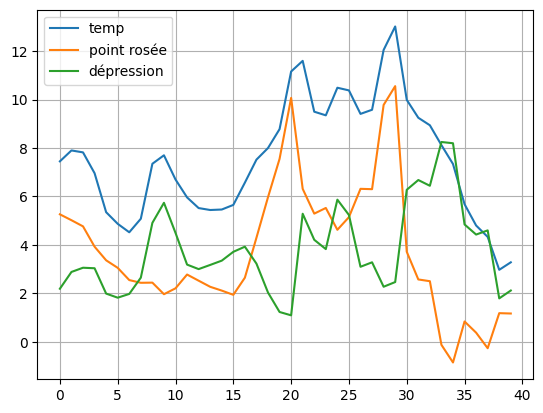

In [136]:
x = np.arange(40)
x_temp = current.temp
x_hum = current.humidity/100

rosee = dewpoint(x_temp,x_hum)
plt.plot(x,x_temp,label='temp')
plt.plot(x,rosee[1],label='point rosée')
plt.plot(x,rosee[2],label='dépression')
plt.grid()
plt.legend()


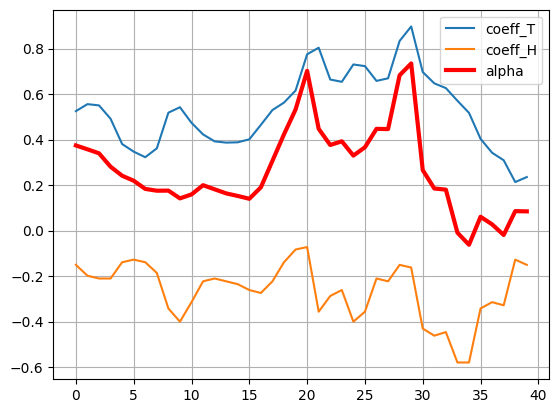

In [137]:
# alpha(temp,hum)
y_temp = a*x_temp/(b+x_temp)
y_hum = np.log(x_hum)
plt.plot(x,y_temp,label='coeff_T')
plt.plot(x,y_hum,label='coeff_H')  # valeurs négatives
f = y_temp+y_hum  # alpha() = y_temp + y_hum
plt.plot(x,f,label='alpha',lw=3,c='red')
plt.grid()
plt.legend()


(237.7, 17.27)

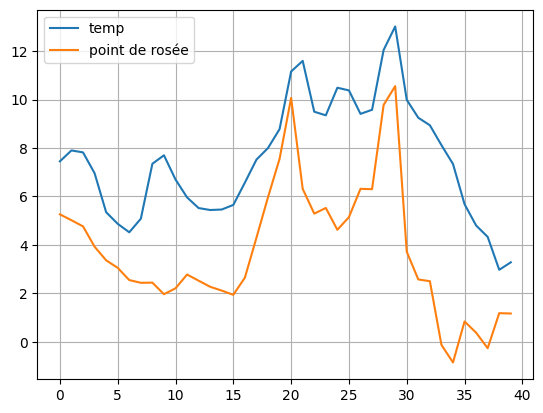

In [138]:
# point de rosée
plt.plot(x,x_temp,label='temp')
plt.plot(x,b*f/(a-f),label='point de rosée')
plt.grid()
plt.legend()
b,a


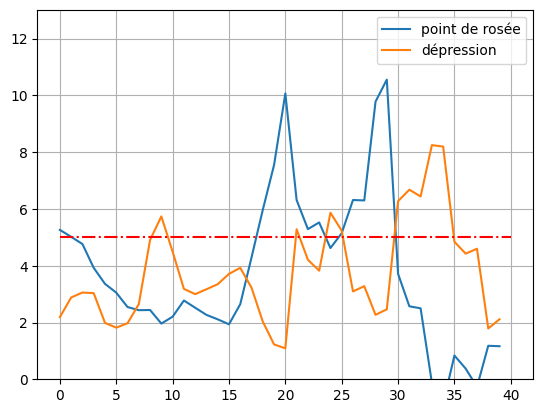

In [139]:
plt.plot(x,b*f/(a-f),label='point de rosée')
plt.plot(x,x_temp - b*f/(a-f),label='dépression')
plt.plot((0,40),(5,5),'r-.')  # si depression < 5, risuqe de nuages et pluie
plt.grid()
plt.ylim(0,max(x_temp))
plt.legend()

In [140]:
# alpha
f = y_temp+y_hum
f, alpha(x_temp,x_hum)


(0     0.374005
 1     0.357058
 2     0.339342
 3     0.280570
 4     0.240884
         ...   
 35    0.060557
 36    0.027128
 37   -0.019538
 38    0.085288
 39    0.084241
 Length: 40, dtype: float64,
 0     0.374005
 1     0.357058
 2     0.339342
 3     0.280570
 4     0.240884
         ...   
 35    0.060557
 36    0.027128
 37   -0.019538
 38    0.085288
 39    0.084241
 Length: 40, dtype: float64)

In [141]:
(x,y_hum)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 0    -0.150823
 1    -0.198451
 2    -0.210721
 3    -0.210721
 4    -0.139262
         ...   
 35   -0.342490
 36   -0.314711
 37   -0.328504
 38   -0.127833
 39   -0.150823
 Name: humidity, Length: 40, dtype: float64)

In [142]:
dewpoint(current.temp[0],current.humidity[0]/100)

(7.45, 5.2616570874863235, 2.1883429125136766)

In [143]:
dewpt = dewpoint(current.temp ,current.humidity/100) 
dewpt[1] # point de rosée

0     5.261657
1     5.018210
2     4.764228
3     3.925466
4     3.362366
        ...   
35    0.836421
36    0.373976
37   -0.268610
38    1.179708
39    1.165150
Length: 40, dtype: float64

In [144]:
dewpt[2]   # dépression

0     2.188343
1     2.881790
2     3.055772
3     3.034534
4     1.987634
        ...   
35    4.843579
36    4.426024
37    4.598610
38    1.790292
39    2.114850
Length: 40, dtype: float64

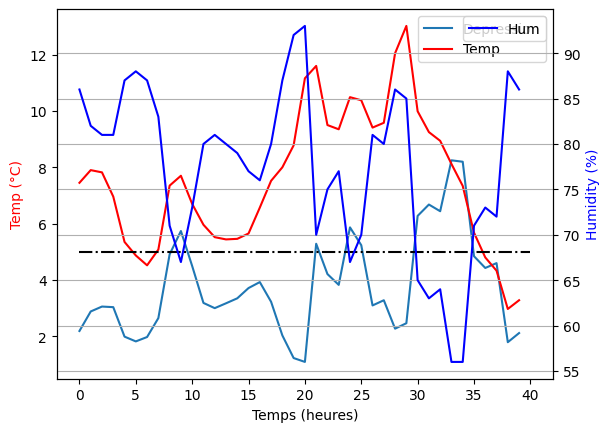

In [145]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dewpt[2],label='Depression')
ax1.plot(current.temp,'r',label='Temp')
ax2.plot(current.humidity,'b',label='Hum')
ax1.plot((0,40),(5,5),'k-.')  # black
#plt.ylim(min(dewpt[2])-2,max(current.temp)+2)
ax1.set_xlabel('Temps (heures)')
ax1.set_ylabel('Temp (°C)', color='r')
ax2.set_ylabel('Humidity (%)', color='b')
ax1.legend()
ax2.legend()
plt.grid()
plt.show()


In [146]:
current.temp.head(),current.h_time.head()

(0    7.45
 1    7.90
 2    7.82
 3    6.96
 4    5.35
 Name: temp, dtype: float64,
 0    13
 1    16
 2    19
 3    22
 4    01
 Name: h_time, dtype: object)

In [147]:
current['dew_point'] = dewpt[1]
current[['h_time','temp','dew_point']]

,h_time,temp,dew_point
0,13,7.45,5.261657
1,16,7.90,5.018210
2,19,7.82,4.764228
3,22,6.96,3.925466
4,01,5.35,3.362366
...,...,...,...
35,22,5.68,0.836421
36,01,4.80,0.373976
37,04,4.33,-0.268610
38,07,2.97,1.179708


In [148]:
current.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   temp        40 non-null     float64       
 1   feels_like  40 non-null     float64       
 2   temp_min    40 non-null     float64       
 3   temp_max    40 non-null     float64       
 4   pressure    40 non-null     int64         
 5   sea_level   40 non-null     int64         
 6   grnd_level  40 non-null     int64         
 7   humidity    40 non-null     int64         
 8   temp_kf     40 non-null     float64       
 9   dt          40 non-null     int64         
 10  dates       40 non-null     datetime64[ns]
 11  h_date      40 non-null     object        
 12  h_time      40 non-null     object        
 13  dew_point   40 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(5), object(2)
memory usage: 4.5+ KB


In [149]:
current.dates

0    2024-12-03 13:00:00
1    2024-12-03 16:00:00
2    2024-12-03 19:00:00
3    2024-12-03 22:00:00
4    2024-12-04 01:00:00
             ...        
35   2024-12-07 22:00:00
36   2024-12-08 01:00:00
37   2024-12-08 04:00:00
38   2024-12-08 07:00:00
39   2024-12-08 10:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

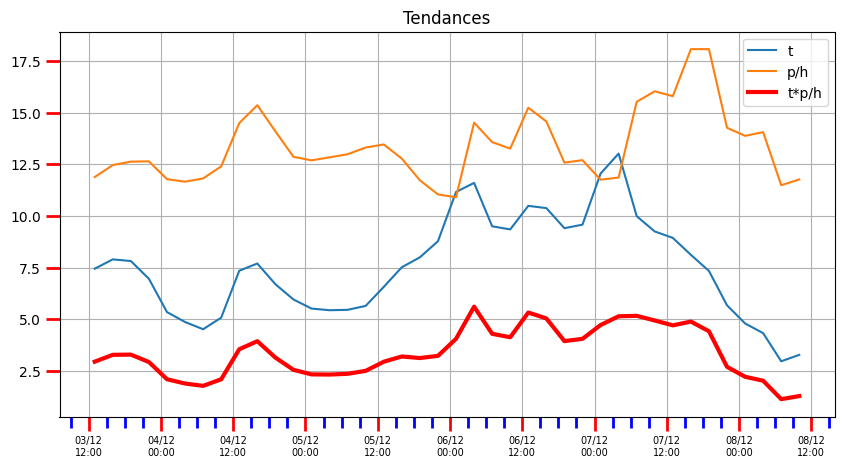

In [150]:
result1=current.temp  #*current.humidity*current.pressure
result2=(current.pressure)/(current.humidity*10)  #p/h est normalisé, on ramène le rapport autour de 1
result3=(current.temp)*result2

fig, ax = plt.subplots()

# nombre de ticks sur axe des x
major_ticks = 1/2                   # toutes les 6 heures pour 1/4, 12h pour 1/2, 3 heures pour 1/8
minor_ticks = major_ticks/4          # denominateur n = n minor ticks 


# format grid
fig.set_size_inches(10, 5)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax.tick_params('x', labelsize=7)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=10, color='r')
ax.tick_params(which='minor', length=8, color='b')

# plot
plt.plot(current.dates, result1,label='t')
plt.plot(current.dates, result2*10,label='p/h')
plt.plot(current.dates, result3/3,label='t*p/h',lw=3,c='red')
plt.legend()
plt.title('Tendances')
plt.grid()

<Axes: >

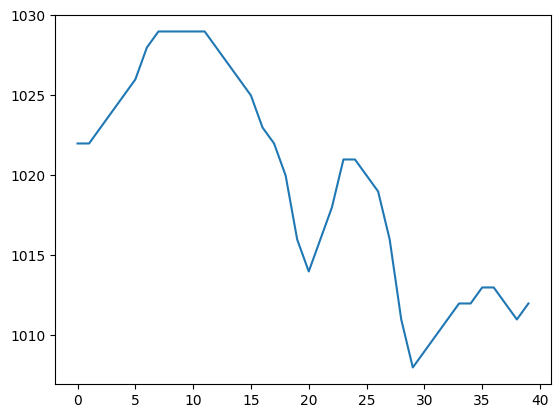

In [151]:
current.pressure.plot()

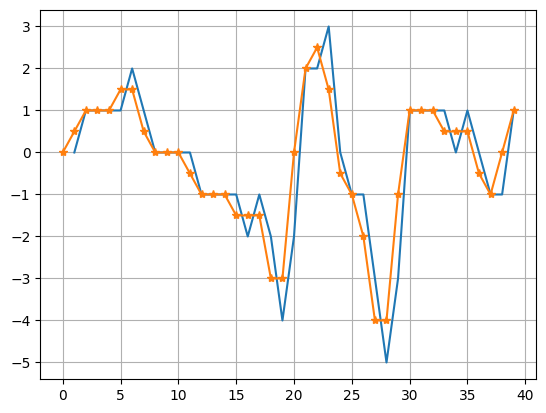

In [152]:
dy.diff().plot()
plt.plot(x,np.gradient(dy, dx), '-*', label='approx')
plt.grid()

In [153]:
len(dy)

40

In [154]:
current.dates

0    2024-12-03 13:00:00
1    2024-12-03 16:00:00
2    2024-12-03 19:00:00
3    2024-12-03 22:00:00
4    2024-12-04 01:00:00
             ...        
35   2024-12-07 22:00:00
36   2024-12-08 01:00:00
37   2024-12-08 04:00:00
38   2024-12-08 07:00:00
39   2024-12-08 10:00:00
Name: dates, Length: 40, dtype: datetime64[ns]

In [155]:
current.h_date

0     03/12/2024 13:00:00
1     03/12/2024 16:00:00
2     03/12/2024 19:00:00
3     03/12/2024 22:00:00
4     04/12/2024 01:00:00
             ...         
35    07/12/2024 22:00:00
36    08/12/2024 01:00:00
37    08/12/2024 04:00:00
38    08/12/2024 07:00:00
39    08/12/2024 10:00:00
Name: h_date, Length: 40, dtype: object

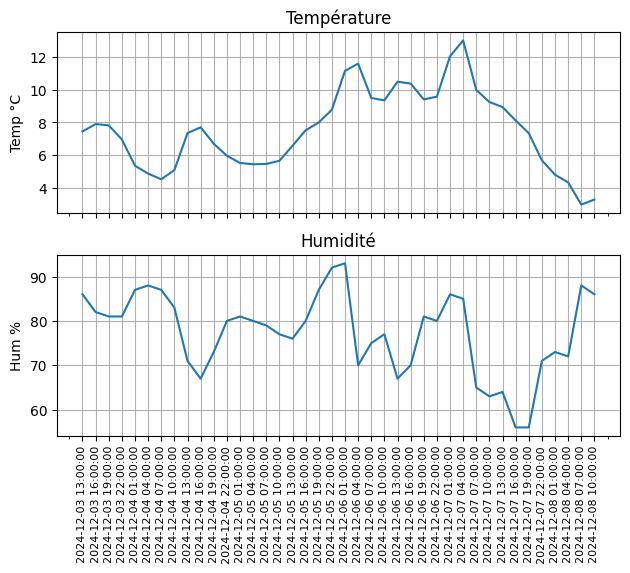

In [156]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True,)
temp = current.temp 
temp.plot(grid=True, ax=ax1)
ax1.title.set_text('Température')
ax1.set_ylabel('Temp °C')
ax2.title.set_text('Humidité')
plt.tight_layout()
current.humidity.plot(grid=True, ax=ax2)
ax2.set_ylabel('Hum %')

ax2.xaxis.set_major_formatter(formatter)
ax2.xaxis.set_major_locator(MultipleLocator(3))  
ax2.xaxis.set_minor_locator(MultipleLocator(1))

ax2.set(xticks=x, xticklabels=current.dates)
ax2.tick_params('x', labelsize=8, rotation=90)

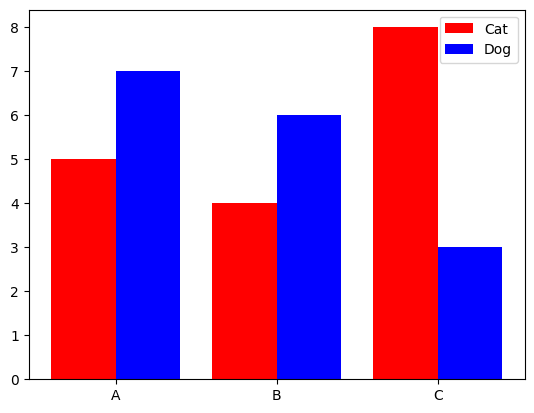

In [157]:
xticks = ['A','B','C']
Scores = np.array([[5,7],[4,6],[8,3]])
colors = ['red','blue']
names = ["Cat", "Dog"]

fig, ax = plt.subplots()

x = np.arange(len(Scores))
ax.bar(x-0.2, Scores[:,0], color=colors[0], width=0.4, label=names[0])
ax.bar(x+0.2, Scores[:,1], color=colors[1], width=0.4, label=names[1])
ax.set(xticks=x, xticklabels=xticks)
ax.legend()
plt.show()

In [158]:
datetime.now().strftime('%d/%m/%Y %H:%M:%S')

'03/12/2024 15:48:31'

# Tendances Météo sur 5 jours

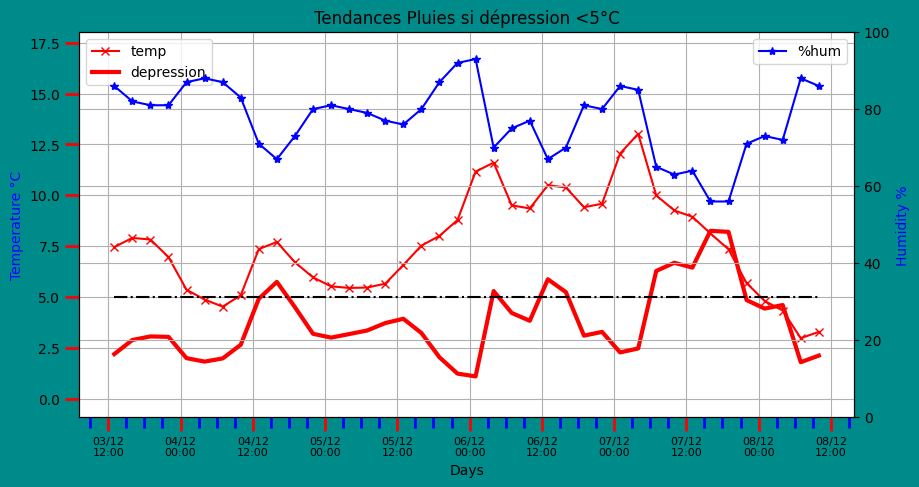

In [159]:
# point de rosée
current['dewpoint']=dewpt[1]
point_rosee = dewpt[1]
# calcul de la dépression
depression = current.temp-point_rosee
current['depression']=depression
fig, ax1 = plt.subplots(facecolor='darkcyan')
ax2 = ax1.twinx()
ax1.set_xlabel('Days')
ax1.set_ylabel('Temperature °C', color='b')
ax2.set_ylabel('Humidity %', color='b')
# format grid
fig.set_size_inches(10, 5)
# graduations axeX
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_major_locator(MultipleLocator(major_ticks))  
ax1.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
ax1.tick_params('x', labelsize=8)  # size of x_axis labels
ax1.tick_params(which='both', width=2)
ax1.tick_params(which='major', length=10, color='r')
ax1.tick_params(which='minor', length=8, color='b')

# plot
ax1.plot(current.dates, temp,'x-',label='temp',color='r')
ax2.plot(current.dates, current.humidity,'*-',label='%hum',color='blue')
#ax1.plot(current.dates, point_rosee,label='point de rosée')#,lw=3,c='red')
# tendances pluie
#lbl = 'depr<5+ "pluie" if depression[0]<5 else ""
ax1.plot(current.dates, depression,label="depression",lw=3,c='red')
#ax1.plot(current.dates, depression+dy.diff(),'-.',label="depression+diffpressure",lw=2,c='blue')
ax1.plot((current.dates[0],current.dates[39]),(5,5),'-.',color='black') 

# https://stackoverflow.com/questions/28095852/set-ylim-on-subplot-secondary-y-axis
ax1.set_ylim(min(depression)-2,max(current.temp)+5)
ax2.set_ylim(0, 100)
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.title('Tendances Pluies si dépression <5°C')
ax1.grid()
ax2.grid()

<Axes: >

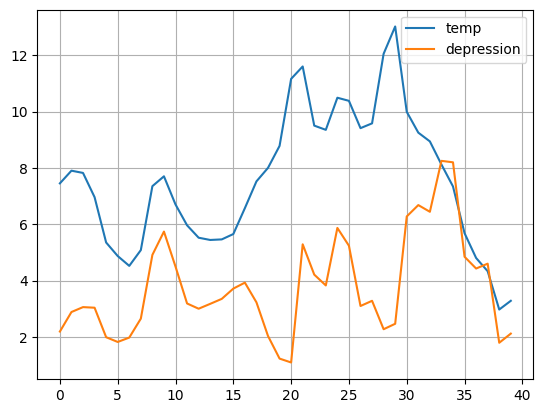

In [160]:
current[['h_date','temp','depression']].plot(grid=True)

In [161]:
d = current['h_date'].apply(lambda x: x[:2]+'\n'+x[11:13])
d

0     03\n13
1     03\n16
2     03\n19
3     03\n22
4     04\n01
       ...  
35    07\n22
36    08\n01
37    08\n04
38    08\n07
39    08\n10
Name: h_date, Length: 40, dtype: object

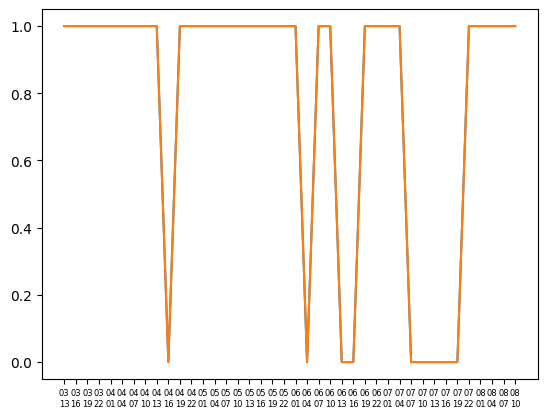

In [162]:
current['tendances']=current['depression'].apply(lambda x: 'pluie' if x<5 else 'beau temps')

trends = np.multiply(current['tendances']=='pluie',1) #== True
#trends.plot()

plt.plot(d,trends)
plt.xticks(fontsize = 6) 
plt.plot(d,trends)

In [163]:
# first 24 h
current[:8][['h_date','temp','depression','tendances']]

,h_date,temp,depression,tendances
0,03/12/2024 13:00:00,7.45,2.188343,pluie
1,03/12/2024 16:00:00,7.90,2.881790,pluie
2,03/12/2024 19:00:00,7.82,3.055772,pluie
3,03/12/2024 22:00:00,6.96,3.034534,pluie
4,04/12/2024 01:00:00,5.35,1.987634,pluie
5,04/12/2024 04:00:00,4.87,1.818564,pluie
6,04/12/2024 07:00:00,4.52,1.974137,pluie
7,04/12/2024 10:00:00,5.08,2.646223,pluie


In [164]:
# next 4 days 
for i in range(1,5):
    print(current[8*i:8*(i+1)][['h_date','temp','depression','tendances']])

                 h_date  temp  depression   tendances
8   04/12/2024 13:00:00  7.35    4.909607       pluie
9   04/12/2024 16:00:00  7.70    5.737611  beau temps
10  04/12/2024 19:00:00  6.70    4.495009       pluie
11  04/12/2024 22:00:00  5.96    3.185055       pluie
12  05/12/2024 01:00:00  5.52    2.999137       pluie
13  05/12/2024 04:00:00  5.44    3.171563       pluie
14  05/12/2024 07:00:00  5.46    3.348432       pluie
15  05/12/2024 10:00:00  5.65    3.712880       pluie
                 h_date   temp  depression   tendances
16  05/12/2024 13:00:00   6.57    3.924880       pluie
17  05/12/2024 16:00:00   7.52    3.225699       pluie
18  05/12/2024 19:00:00   8.00    2.031032       pluie
19  05/12/2024 22:00:00   8.78    1.227844       pluie
20  06/12/2024 01:00:00  11.16    1.090043       pluie
21  06/12/2024 04:00:00  11.60    5.285535  beau temps
22  06/12/2024 07:00:00   9.50    4.209486       pluie
23  06/12/2024 10:00:00   9.35    3.825756       pluie
                 h_